# Closed-Form Solutions to Multiple-View Homography Estimation
This noteboook contains the implementation of the graph synchronization method that can be used to solve the stitching problem in case of multiple images. The implementation resamble the procedure explained in Shroeder et al. 2011.

In [301]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx as nx

## Variables definition

In [302]:
#Directories
dataset_name = 'mountain_dataset_noise'
dataset_dir = f'datasets/{dataset_name}'
output_dir ="output"

In [303]:
#If true store the computed images on disk
M_filename = f"M_{dataset_name}.npy"
C_filename = f"C_{dataset_name}.npy"

In [304]:
#This function loads images from a specific folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

In [305]:
#This function splits a 3nx3n matrix into a set of 3x3 matrices
def get_states(x):
    x_small = x.transpose()
    res = [ x_small[:,i*3:(i+1)*3].transpose() for i in range(x_small.shape[1]//3)]
    return res

In [306]:
import skimage

# This function allows to stitch images together
def stitch_images(U, imgs, idx_ref, num, idxs=None, beautify=True):
    if not idxs:
        idxs = list(range(num))
    
    #Compute the homography of each image w.r.t. the reference one
    H = [np.dot(U[i],np.linalg.inv(U[idx_ref])) for i in range(num)]
    
    rescale = 1./np.max(imgs[idx_ref].shape)
    T_norm = np.diag([rescale,rescale,1])
    
    H = [ np.linalg.inv(T_norm) @ h @ T_norm  for h in H]
    
    min_x = 0
    min_y = 0
    max_x = 0
    max_y = 0
    
    #For each image
    for i in idxs:
        
        print(np.linalg.det(H[i]))
        
         ## translate
        (Height, Width, _) = imgs[i].shape

        # Taking the matrix of initial coordinates of the corners of the secondary image
        # Stored in the following format: [[x1, x2, x3, x4], [y1, y2, y3, y4], [1, 1, 1, 1]]
        # Where (xt, yt) is the coordinate of the i th corner of the image. 
        InitialMatrix = np.array([[0, Width - 1, Width - 1, 0],
                                  [0, 0, Height - 1, Height - 1],
                                  [1, 1, 1, 1]])

        # Finding the final coordinates of the corners of the image after transformation.
        # NOTE: Here, the coordinates of the corners of the frame may go out of the 
        # frame(negative values). We will correct this afterwards by updating the 
        # homography matrix accordingly.
        FinalMatrix = np.dot(np.linalg.inv(H[i]), InitialMatrix)

        [x, y, c] = FinalMatrix
        x = np.divide(x, c)
        y = np.divide(y, c)

        c_min_x = min(x)
        c_min_y = min(y)
        c_max_x = max(x)
        c_max_y = max(y)
        
        if c_min_x < min_x:
            min_x = c_min_x
            
        if c_min_y < min_y:
            min_y = c_min_y
            
        if c_max_x > max_x:
            max_x = c_max_x
            
        if c_max_y > max_y:
            max_y = c_max_y

            
    size =  [5000,10000] # y,x
    
    if beautify:
        t = [-min_x,-min_y]
        dy = int(min(max_y - min_y, size[0]))
        dx = int(min(max_x - min_x, size[1]))
        size = [dy,dx]
    else:
        t = [0,0]        
    print(t, size)
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
    
    stitch = np.zeros(size + [3], dtype=int)
       
    #For each image
    for i in idxs:
    
        # debug
        #print(x)
        #print(y)

        #H_proj = np.dot(H[i],Ht)

        #Apply the homography        
      #  img_proj = skimage.transform.warp(imgs[i], H[i],output_shape= size)
        img_proj = cv.warpPerspective(imgs[i], Ht @ np.linalg.inv(H[i]) , size[::-1])
        #plt.imshow(img_proj[:1000,:1000],),plt.show()
        
        
        
        #Use maximum as stitch operator (very simple stitching mechanism)
        stitch = np.maximum(stitch,img_proj)
   
    
    return H, stitch

## Computation of the solution of the graph synchronization problem

In [307]:
#Load images from the folder
imgs = load_images_from_folder(dataset_dir)
n = len(imgs) #Number of images
print(n)

#Load M,C matrix
M = np.load(os.path.join(output_dir,M_filename))
C = np.load(os.path.join(output_dir,C_filename))

6


In [308]:
S = (np.eye(M.shape[0])-C@np.linalg.pinv(C))@M.transpose()@M

In [309]:
w,v = np.linalg.eig(S)

In [310]:
w = np.real(w)
v = np.real(v)

In [311]:
d = 3
if C.size == 0:
    off = 0
else:
    off = np.linalg.matrix_rank(C)
indx = np.argsort(w)
indxs = np.array([indx]*indx.shape[0])

In [312]:
w_sort = w[indx]
v_sort = np.take_along_axis(np.real(v), indxs, axis=1)

In [313]:
u_hat = v_sort[:,off:d+off]

In [314]:
u_hat.shape

(18, 3)

In [315]:
U = get_states(u_hat) #Get the state of each node

## Stitch images together

In [316]:
_,stitch = stitch_images(U, imgs, 1, n, beautify=True) #Stitch all the images

1.0001646061495644
0.9999999999999998
1.0033018661980289
1.0031024561518593
0.9999420527435556
0.9993757874925893
[2279.4352035899233, 40.676928845670936] [2123, 3077]


In [ ]:
figure(figsize=(40, 40), dpi=80)
plt.imshow(stitch,),plt.show() #Plot stitched image

In [ ]:
figure(figsize=(40, 40), dpi=80)
plt.imshow(stitch,),plt.show() #Plot stitched image

In [19]:
#The remaining part is just to stitch 2 images without applying the graph synchronization method
i1 = 1
i2 = 0

rescale = 1./np.max(imgs[i1].shape)
T_norm = np.diag([rescale,rescale,1])

h = M[(i2)*3:(i2+1)*3,(i1)*3:(i1+1)*3]

im_1 = cv.warpPerspective(imgs[i1 % n], np.eye(3), [10000,5000])
im_2 = cv.warpPerspective(imgs[i2 % n], np.linalg.inv( np.linalg.inv(T_norm) @ h @ T_norm), [10000,5000])  #np.dot(np.dot(np.linalg.inv(T_norm),h),T_norm)

In [20]:
stitch = np.maximum(im_1,im_2)

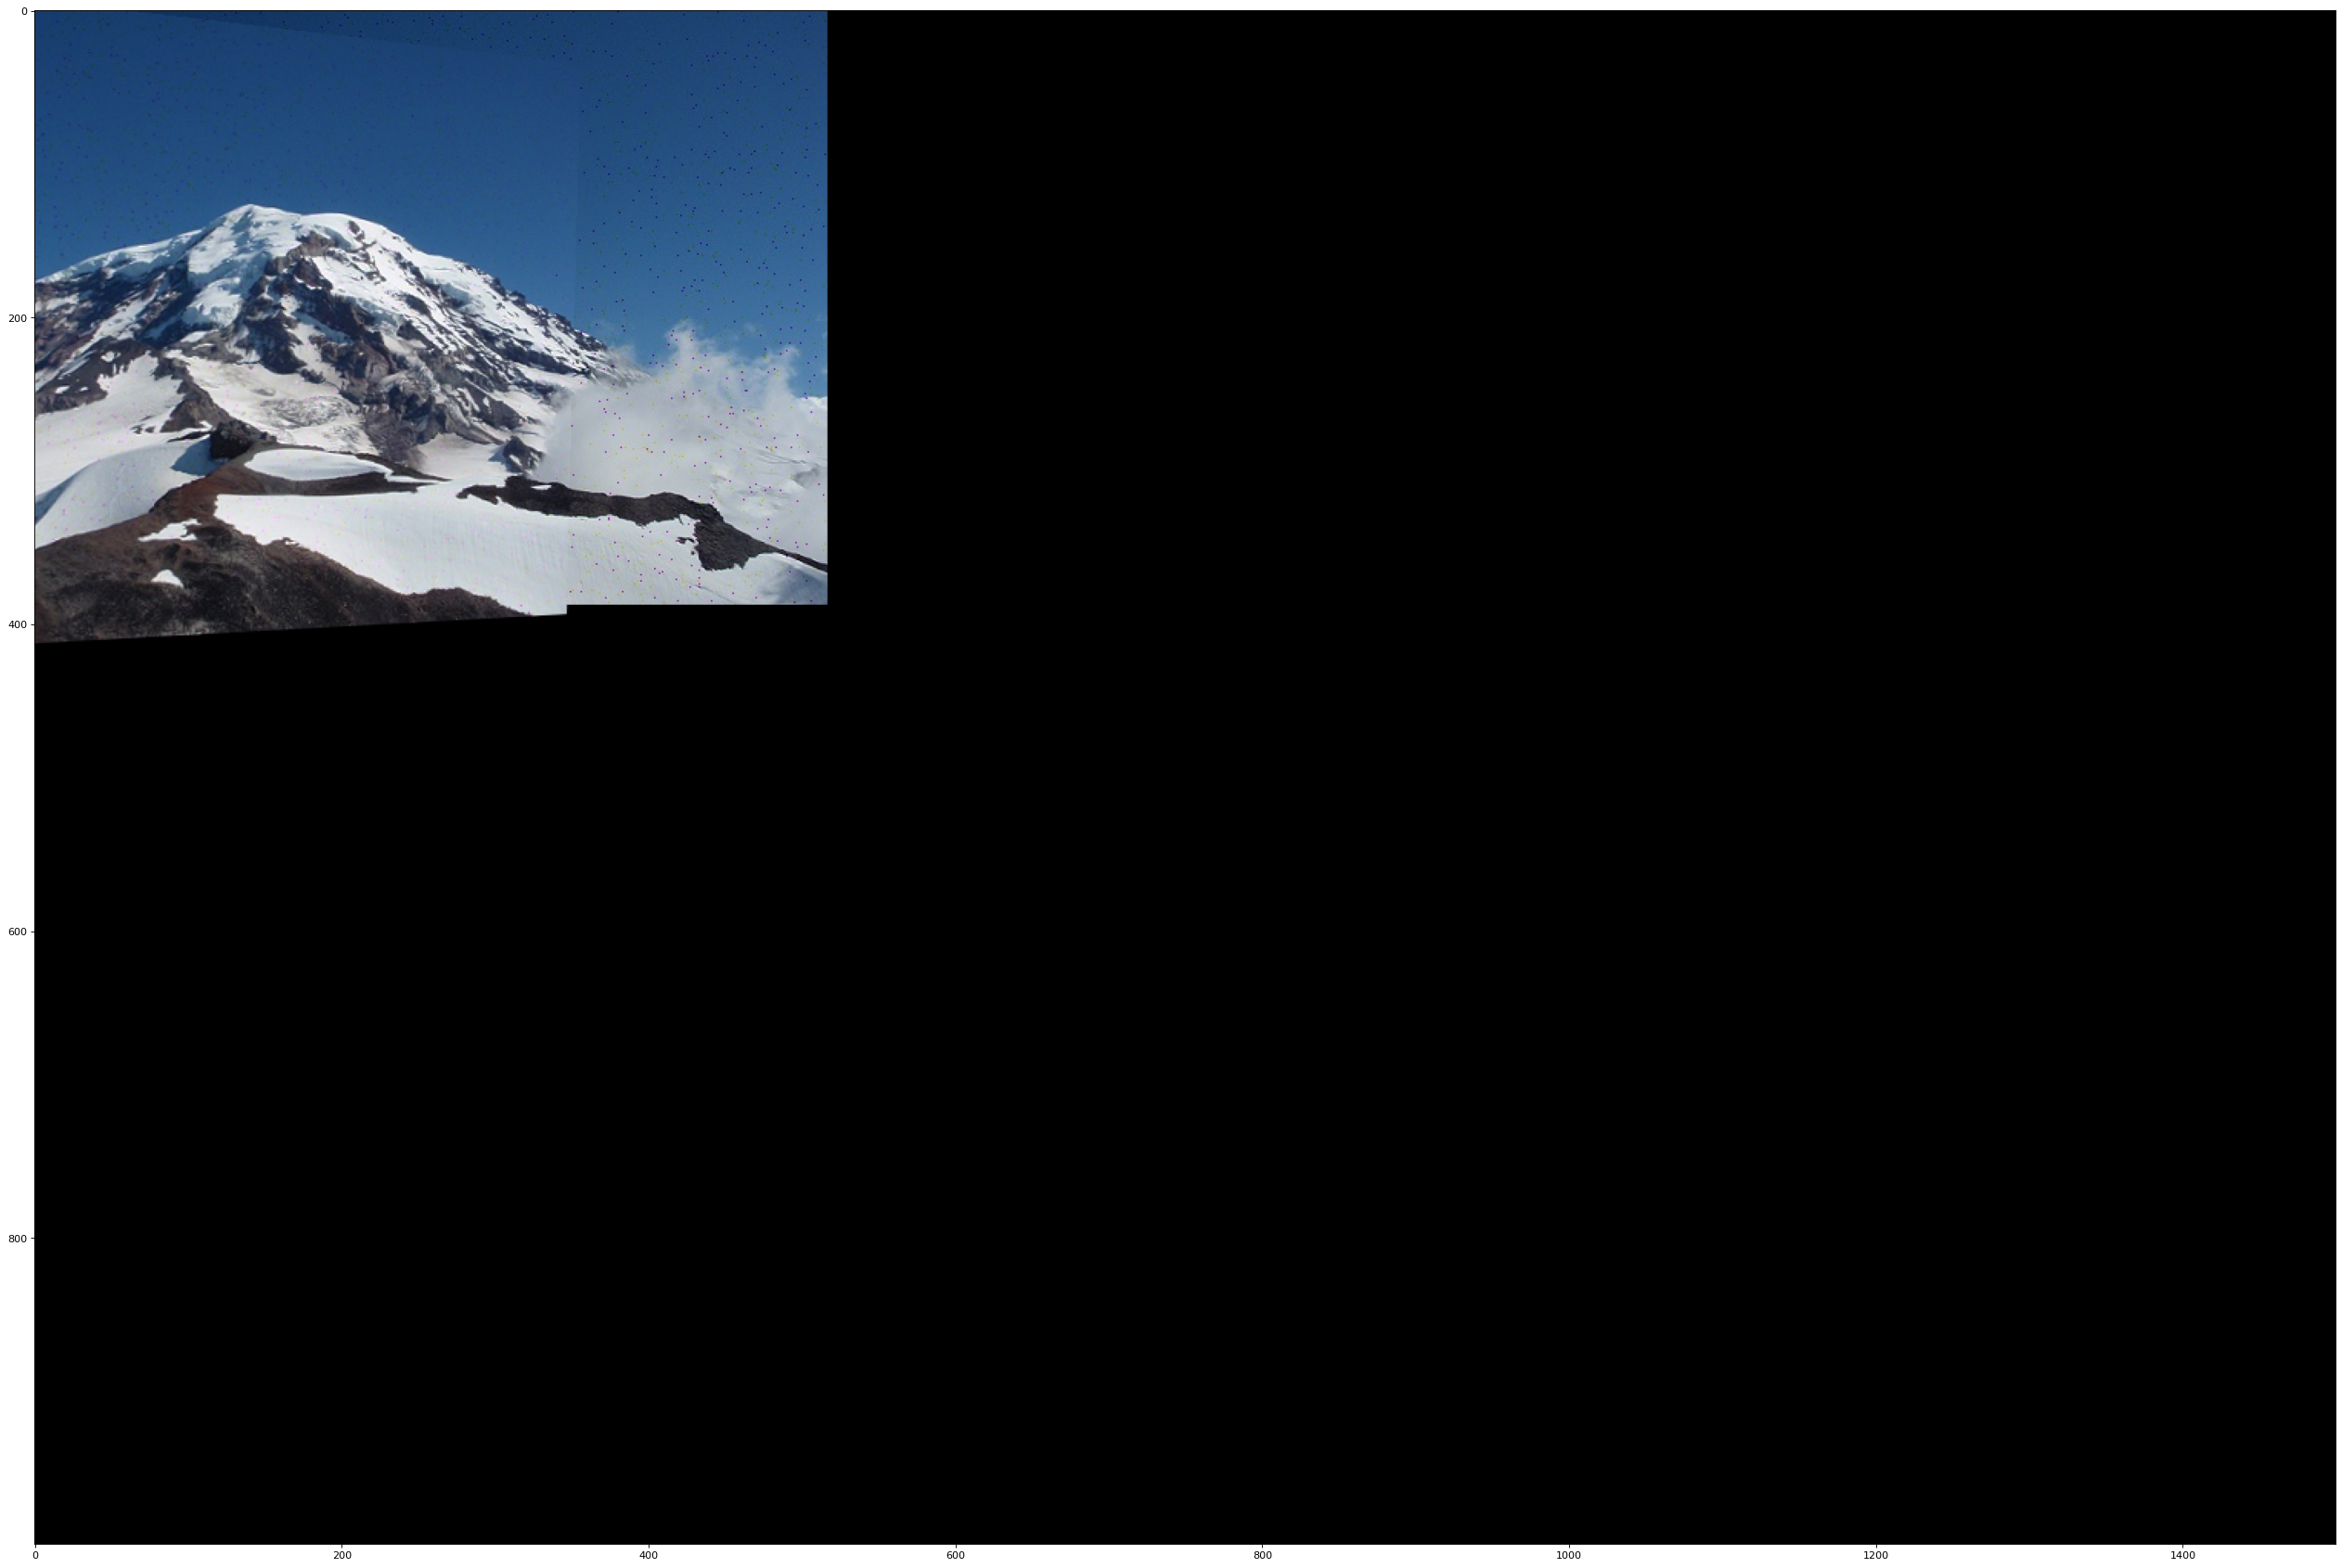

(<matplotlib.image.AxesImage at 0x2502f618280>, None)

In [21]:
from matplotlib.pyplot import figure
figure(figsize=(40, 40), dpi=80)
plt.imshow(stitch[:1000,:1500],),plt.show()